# Best focus algorithm

In [1]:
import os
import cv2
import time
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal


In [2]:
# Functions

def get_focal_position(im):
    # Given an image stack im of dimensions (t, y, x),
    # returns int representing best focus t-index.
        
    # Num z-stacks
    num_z = np.shape(im)[0]
    
    # List of focus values (var of lap)
    focus_vals = []
    
    # Open every nuclear image
    for i in range(num_z):
        
        # Calculate the variance of the laplacian to measure focus. Bigger is better
        focus_vals.append(cv2.Laplacian(im[i,:,:], cv2.CV_64F).var())
    
    # Return best focus image
    best_focus_ind = np.argmax(focus_vals)
    
    return best_focus_ind


def subtile_im(im, split_size):
    # Given an image im of dimension (t, y, x),
    # and the size of the subtiled images split_size,
    # returns a dictionary of split images
    # with tile coordinate, subtiled images as key-value pairs.
    
    # Create dictionary to contain tiled images
    split_im_dict = {}
    
    # Get number of tiles in x and y
    num_y = int(np.ceil(np.shape(im)[1] / split_size))
    num_x = int(np.ceil(np.shape(im)[2] / split_size))
    
    # Iteratively split up images and add to split_image_dict, keyed by tile coordinate
    for y in range(num_y):
        for x in range(num_x):
            split_im_dict[(y,x)] = im[:,
                                      y*split_size:min(np.shape(im)[1], split_size*(y+1)),
                                      x*split_size:min(np.shape(im)[2], split_size*(x+1))]
            
    return split_im_dict
    

def get_trimmed_bestfocus_tiles(im, tile_size):
    # Given an image im of dimension (t, y, x)
    # and an int tile_size,
    # returns an array of best focus for each tile
    # after splitting image into square tiles of size tile_size
    
    # Split the image into a dictionary of subtiled images
    sub_tiled_im = subtile_im(im, tile_size)
    
    # Initialize zeros array of dims 
    num_y_tiles = list(sub_tiled_im.keys())[-1][0]+1
    num_x_tiles = list(sub_tiled_im.keys())[-1][1]+1
    best_foc_array = np.zeros((num_y_tiles, num_x_tiles))
    
    # Iterate over subimages and find best focus
    for key in sub_tiled_im:
        best_foc_array[key] = get_focal_position(sub_tiled_im[key])
    
    bf_mean = np.mean(best_foc_array)
    bf_std = np.std(best_foc_array)
    
    # trim min max
    best_foc_array_trimmed = np.minimum(int(bf_mean+2*bf_std), best_foc_array)
    best_foc_array_trimmed = np.maximum(int(bf_mean-2*bf_std), best_foc_array_trimmed)
    
    return best_foc_array_trimmed


def subtiled_best_focus(im, bin_sizes):
    # Given an image, and a list of bin size,
    # plots best focus heatmap for images binned by bin size

    for size in bin_sizes:
        
        # get binned best focus tiles
        tiled_bf = get_trimmed_bestfocus_tiles(im, size)
    
        # plot
        plt.figure()
        fig = plt.imshow(tiled_bf)
        plt.colorbar(fig, shrink=0.84)
        plt.title(f'Tile size: {size}')
        plt.axis('off')


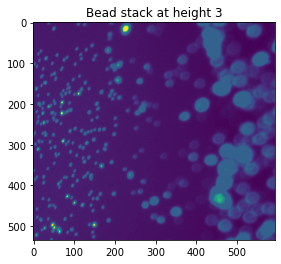

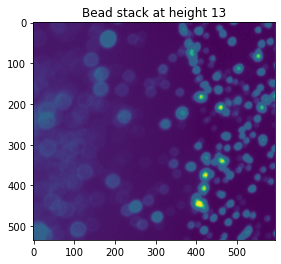

In [3]:
# Load an plot raw data

# get source dir
source_im_dir = os.path.normpath(r'HeightsData/inoculate_beads.tif')

# load image
bead_stack = tifffile.imread(source_im_dir)

# Plot bead stack at varying heights
plot_heights = [3, 13]

for height in plot_heights:
    plt.figure()
    plt.imshow(bead_stack[height,...])
    plt.title(f'Bead stack at height {height}')


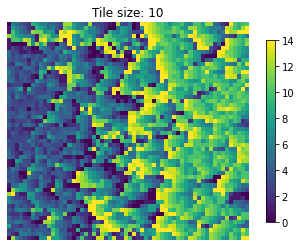

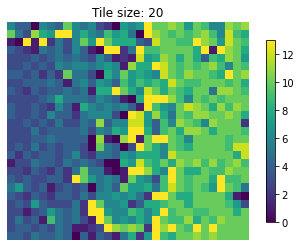

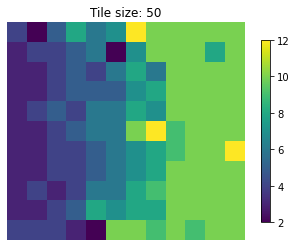

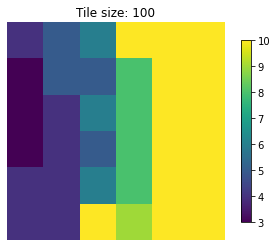

In [4]:
# Iteratively plot best focus for different binning levels

tile_bin_sizes = [10,20,50,100]
subtiled_best_focus(bead_stack, tile_bin_sizes)
